k-NN to identify 

Import packages

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt

Function to display in notebook

In [2]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

Load a Malignant image

In [3]:
args = {
	"benign": "sample-images/benign/0.jpg",
    "malignant": "sample-images/malignant/0.jpg",
	"normal": "sample-images/normal/0.jpg"
}

Load Malignant image from disk and display

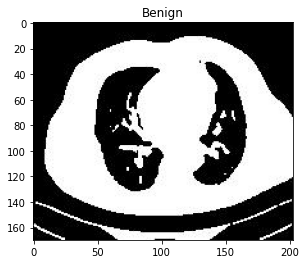

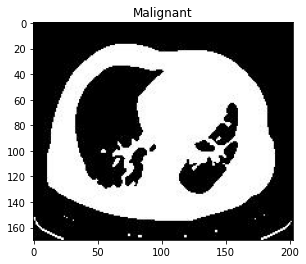

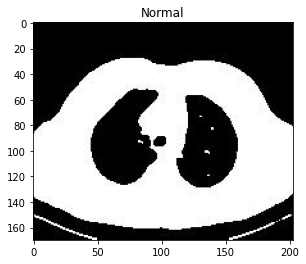

In [5]:
# loads the image set above from disk into image
beni = cv2.imread(args["benign"])
(h, w, c) = beni.shape[:3]

# show the image and wait for keypress
plt_imshow("Benign", beni)

# loads the image set above from disk into image
mal = cv2.imread(args["malignant"])
(h, w, c) = mal.shape[:3]

# show the image and wait for keypress
plt_imshow("Malignant", mal)

# loads the image set above from disk into image
norm = cv2.imread(args["normal"])
(h, w, c) = norm.shape[:3]

# show the image and wait for keypress
plt_imshow("Normal", norm)

Build image preprocessor

In [6]:
class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# resize the image to a fixed size, ignoring the aspect
		# ratio
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

Build image loader

In [7]:
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

Implement k-NN

In [8]:
args = {
	"dataset": "dataset/tumors",
	"neighbors": 1,
	"jobs": -1
}

Get list of images to process

In [10]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))

# init the image preprocessor
# load dataset from disk
# reshape the matrix
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.reshape((data.shape[0], 3072))

# show info on mem consumption
print("[INFO] features matrix: {:.1f}MB".format(
	data.nbytes / (1024 * 1024.0)))

[INFO] loading images...
[INFO] processed 500/1050
[INFO] processed 1000/1050
[INFO] features matrix: 3.1MB


Encode integers

In [11]:
le = LabelEncoder()
labels = le.fit_transform(labels)

# split the data into train and  test 75% : 25%
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

Train and evaluate k-NN classifier

In [12]:
print("[INFO] evaluating k-NN classifier...")
model = KNeighborsClassifier(n_neighbors=args["neighbors"],
        n_jobs=args["jobs"])

model.fit(trainX, trainY)
print(classification_report(testY, model.predict(testX),
        target_names=le.classes_))

[INFO] evaluating k-NN classifier...
              precision    recall  f1-score   support

      benign       0.99      1.00      0.99        92
   malignant       1.00      0.99      0.99        93
      normal       0.99      0.99      0.99        78

    accuracy                           0.99       263
   macro avg       0.99      0.99      0.99       263
weighted avg       0.99      0.99      0.99       263

